# p-Median

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-Description" data-toc-modified-id="Problem-Description-1">Problem Description</a></span><ul class="toc-item"><li><span><a href="#p-Median" data-toc-modified-id="p-Median-1.1">p Median</a></span></li><li><span><a href="#Integer-programming-model:" data-toc-modified-id="Integer-programming-model:-1.2">Integer programming model:</a></span></li></ul></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2">Setup</a></span></li><li><span><a href="#Example" data-toc-modified-id="Example-3">Example</a></span><ul class="toc-item"><li><span><a href="#Random-Data" data-toc-modified-id="Case1.-Solving-p-Median-problem-with-synthetic-data-3.1">Case1. Solving p-Median problem with synthetic data</a></span></li><li><span><a href="#Road-Network-Data" data-toc-modified-id="Road-Network-Data-3.2">Case2. Solving p-Median problem with real-world data</a></span></li></ul></li></ul></div>

## Problem Description

### p-Median Problems <sup>[1]</sup>

The p-median is a location assignment model that locates a given number of facilities $p$ and assigns demand node $i$ to facility $j$ in order to **minimize the total distance from the demand points to the facility**. In other words, we want to choose $p$ facilities from potential facility locations as median to minimize the total distance between the demand nodes and the location where the facility is placed, and each demand point should be assigned to their nearest medians. 


*Parameters*:
* **$I$** : Collection of demand point locations
* **$h_i$** : Number of customers at point $i$
* **$P$** : Total number of facilities
* **$d_{ij}$** : Distance between point $i$ and point $j$

*Decision variables*:
$$
X_i= \begin{cases}1, & \text { Build facilities at point } i \\ 0, & \text { else }\end{cases}\\
Y_{i j}= \begin{cases}1, & \text { Assign point } i \text { to point } j  \\ 0, & \text { else }\end{cases}
$$

###  Integer programming model:
\begin{array}{lll}
\min & \sum_{i, j \in I} h_i d_{i j} Y_{i j} & (1)\\
\text { s.t. } & \sum_{i \in I} X_i=P, & (2)\\
& Y_{i j} \leq X_j,  \forall i, j \in I, & (3) \\
& \sum_{j \in I} Y_{i j}=1,  \forall i \in I, & (4)\\
& X_i, Y_{i j} \in\{0,1\}, \forall i, j \in I.  & (5)
\end{array}

The objective function (1) requires the minimum total distance between the demand point and the candidate facility. Constraint (2) indicates that only $p$ candidate facilities can be selected.Constraint (3) indicates that demand points are only allowed to be assigned to locations with facilities. Constraint (4) ensures that each demand point $i$ can only be served by one candidate facility point $j$.
     
[1] Hakimi S L. Optimum locations of switching centers and the absolute centers and medians of a graph[J]. Operations research, 1964, 12(3): 450-459.

## Setup

### Set up the environment by importing libraries
import numpy, pulp, matplotlib, pandas and Hispot libraries to set up an environment

In [2]:
import random
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
from hispot.FLP import PMedian

PuLP is an open source linear programming package (actually also includes integer programming). You can use `pip install pulp` to start. 

PuLP supports many open-source linear programming solvers, such as `CBC` and `GLPK`. In addition, PuLP also supports commercial solvers such as `Gurobi` and IBM's `CPLEX`. Notice: these commercial solvers might need licenses to deal with the large-scale problem.  
The default solver after installing PuLP is CBC. This open-source solver from COIN-OR is sufficient for solving most problems.
You can use `listSolvers(onlyAvailable=True)` to check the other available solvers.

In [3]:
np.random.seed(0) # random seed
solver_list = listSolvers(onlyAvailable=True)
print(solver_list) 

['GUROBI_CMD', 'PULP_CBC_CMD']


## Examples

In this part, we will input synthetic data and real-world data and display them as two examples to represent random cases and real-world scenarios, respectively.

### Case1. Solving p-Median problem with synthetic data

Generate problem with synthetic data

In [4]:
num_points = 50
num_located = 8  # P: number of located facility in the end
np.random.seed(0)
points = [(random.random(), random.random()) for i in range(num_points)]
points_np = np.array(points)

Output optimal solution

In [5]:
%%time
centers, assigns, obj = PMedian(num_points=num_points,
                                points=points_np,
                                solver=PULP_CBC_CMD(),
                                num_located=num_located).prob_solve()

Status: Optimal
Centers = [2, 9, 10, 14, 15, 39, 41, 47]
Assigned relationships =  {2: [6, 7, 19, 24, 27, 31, 37, 42], 9: [3, 4, 17, 22, 30, 40, 49], 10: [12, 21], 14: [11, 20, 26, 34, 48], 15: [1, 29, 45], 39: [13, 18, 33, 36], 41: [5, 8, 35, 38, 43, 44], 47: [0, 16, 23, 25, 28, 32, 46]}
Minimum total distance =  5.267064664087335
CPU times: total: 141 ms
Wall time: 511 ms


Visualize optimal solution

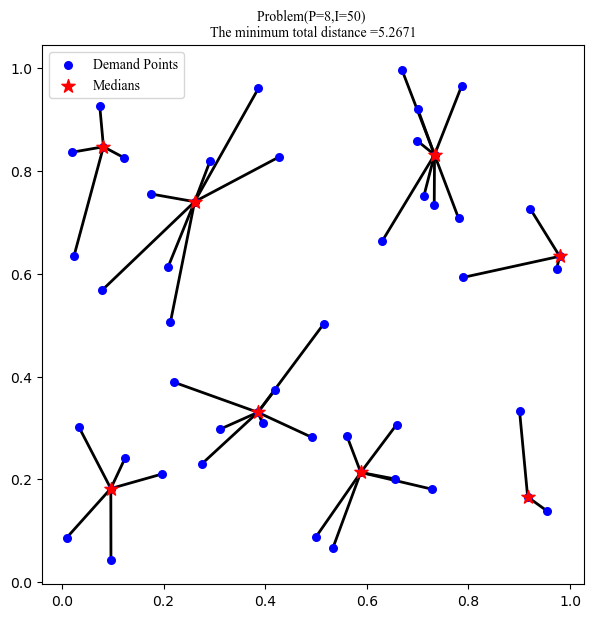

In [8]:
plt.figure(figsize=(7,7))
name = 'Problem(P=' + str(num_located) + ',I=' + str(num_points) + ') \nThe minimum total distance =' + str(round(obj,4))
plt.title(name, fontsize = 15,font = 'Times New Roman')

#Points
plt.scatter(*zip(*points_np), c='Blue', marker='o',s=30, label = 'Demand Points', zorder=2)
plt.scatter(*zip(*points_np[centers]), c='Red', marker='*',s=100,label = 'Medians',zorder=3)
#Lines
for i in assigns:
    center_point = points_np[i]
    for j in assigns[i]:
        demand_points = points_np[j]
        pts = [points[i], points[j]]
        plt.plot(*zip(*pts), c='Black', linewidth=2, zorder=1)
# plt.grid(True)   
plt.legend(loc='best',prop='Times New Roman',fontsize=12)
plt.show()

### Case2. Solving p-Median problem with real-world data

import `geopandas`, `geoplot` to plot the real world map.

In [9]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from math import *

We select Changping District of Beijing the study area and read partial poi points in Xicheng District.

In [31]:
%%time
region=gpd.read_file("../data/beijing/xicheng/xicheng.shp")
region.head(2)

CPU times: total: 15.6 ms
Wall time: 20.3 ms


,Name,Layer,geometry
0,牛街街道,乡镇,"POLYGON ((116.35744 39.88798, 116.36069 39.887..."
1,西长安街街道,乡镇,"POLYGON ((116.37223 39.89854, 116.36903 39.898..."


Partial POI data in Changping district

In [32]:
%%time
poi = gpd.read_file("../data/beijing/xicheng/xicheng-poi.shp")


CPU times: total: 15.6 ms
Wall time: 18.6 ms


In [33]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

Visualization of the input data by geoplot

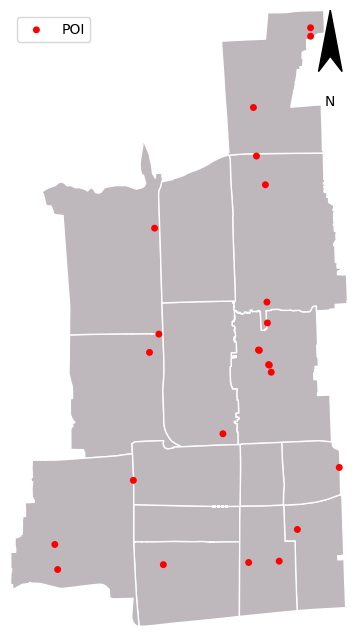

In [34]:
ax = gplt.polyplot(region,
                   projection=gcrs.AlbersEqualArea(),
                   edgecolor="white", facecolor="#BEB8BC",
                   figsize=(10, 8))
gplt.pointplot(poi, 
               extent=region.total_bounds,
               s=5,
               color='red',
               alpha=1,
               linewidth=0,
               label='POI',
               ax=ax)
plt.legend(loc='upper left')
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.05,ratio = 0.7)

Generate problem with real-world data

In [35]:
def get_coordinate(longitude, latitude):
    # lo is the longitude of the location;
    # la is the latitude of the location;

    # coordinate transformation
    R = 6537
    lo = np.mean(longitude)
    la = np.mean(latitude)
    x = R*(longitude-lo)*cos(la)
    y = R*(latitude-la)
    return x,y

In [37]:
data = poi[['lon', 'lat']]
num_points = poi.shape[0]
num_located = 6
x,y=get_coordinate(data['lon'], data['lat'])
pointsxy = [(x[i], y[i]) for i in range(num_points)] # x,y
pointsxy_np = np.array(pointsxy)
points = [(data['lon'][i],data['lat'][i]) for i in range(num_points)] 
points_np = np.array(points)

Output optimal solution

In [38]:
centers, assigns, obj = PMedian(num_points=num_points,
                                points=pointsxy_np,
                                solver=PULP_CBC_CMD(),
                                num_located=num_located).prob_solve()

Status: Optimal
Centers = [1, 4, 6, 9, 12, 17]
Assigned relationships =  {1: [8, 15, 20], 4: [0, 3, 10, 11, 13, 16, 19], 6: [18, 22], 9: [2], 12: [5, 23], 17: [7, 14, 21]}
Minimum total distance =  887.7051181096241


prepare the LineString and center Points to plot the solution

In [39]:
from shapely.geometry import LineString
crs = 'EPSG:4326'
lines = gpd.GeoDataFrame(columns=['id', 'geometry'], crs=crs)
k = 0
for i in assigns:
    center = points_np[i]
    for j in assigns[i]:
        assign = points_np[j]
        line = LineString([center, assign])
        lines.loc[k] = [k+1, line]
        k = k+1
center_points = poi.iloc[centers]

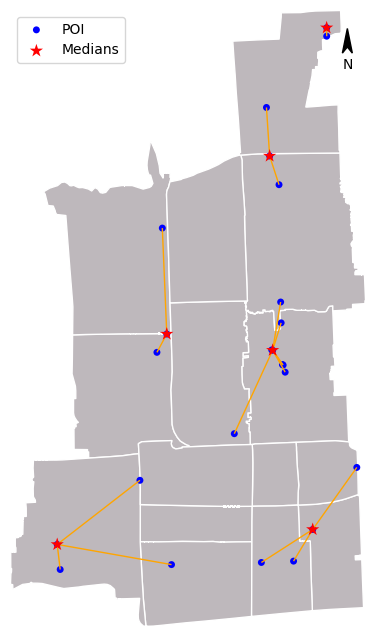

In [41]:
ax = gplt.sankey(lines, 
                 projection=gcrs.Mollweide(),
                 linewidth=1,
                 color='orange',
                 zorder=3,
                 figsize=(10, 8),)
gplt.polyplot(region,
              projection=gcrs.AlbersEqualArea(),
              edgecolor="white", 
              facecolor="#BEB8BC",
              zorder=1,
              ax=ax,)
gplt.pointplot(poi, 
               extent=region.total_bounds,
               s=5,
               color='blue',
               alpha=1,
               linewidth=0,
               label='POI',
               zorder=2,
               ax=ax)
gplt.pointplot(center_points, 
               extent=region.total_bounds,
               s=10,
               color='red',
               alpha=1,
               linewidth=0,
               marker='*',
               label='Medians',
               zorder=4,
               ax=ax)
render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.02,ratio = 0.7)
plt.legend(loc='upper left')